In [5]:
# Import packages
import pandas as pd
import numpy as np
import scipy.stats as stats
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.dpi'] = 300

#### Import data

In [6]:
# Import gene lists
Asterias = []
with open("Data/Asterias.rubens.genelist.bed") as f:
    for line in f:
        Asterias.append(line.strip().split())

A_data = pd.DataFrame(Asterias, 
                     columns = ['Chromosome', 'Start', 'End', 'Name', 'Dot'])
 
Holothuria = []
with open("Data/Holothuria.leucospilota.genelist.bed") as f:
    for line in f:
        Holothuria.append(line.strip().split())

H_data = pd.DataFrame(Holothuria, 
                     columns = ['Chromosome', 'Start', 'End', 'Name', 'Dot'])

Paracentrotus = []
with open("Data/Paracentrotus.lividus.genelist.bed") as f:
    for line in f:
        Paracentrotus.append(line.strip().split())

P_data = pd.DataFrame(Paracentrotus, 
                     columns = ['Chromosome', 'Start', 'End', 'Name', 'Dot'])

# Import orthologs
AH_orthology = np.loadtxt("Data/Asterias.rubens+Holothuria.leucospilota.txt", dtype = "str")

AP_orthology = np.loadtxt("Data/Asterias.rubens+Paracentrotus.lividus.txt", dtype = "str")
AP_orthology = pd.DataFrame(AP_orthology, columns = ['Code', 'A', 'P'])

HP_orthology = np.loadtxt("Data/Holothuria.leucospilota+Paracentrotus.lividus.txt", dtype = "str")

#### Sorting out the data

In [7]:
# AP orthologies: remove prefixes on gene names
AP_orthology['P'] = AP_orthology['P'].str.removeprefix('Parliv_')
AP_orthology = AP_orthology.to_numpy()

# Asterias data: removing non-chromosomal values
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 
        'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 
        'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 
        'chr19', 'chr20', 'chr21', 'chr22', 'chr23']

A_data = A_data.loc[A_data['Chromosome'].isin(chromosomes)]

# Paracentrotus data: Calculate number of genes on each scaffold
P_ortho = P_data.groupby('Chromosome').size()
P_ortho = P_ortho.reset_index()

P_ortho.columns = ['Chromosome', 'Count']
P_ortho = P_ortho.loc[P_ortho['Count'] >= 100]

scaffolds = P_ortho.Chromosome.tolist() # Remove all values from non-chromosome scaffolds
P_data = P_data.loc[P_data['Chromosome'].isin(scaffolds)]

-----

### Define functions

In [8]:
def orthodata(speciesA, speciesB, genelistA, genelistB, orthologies):
    
    """
    inputs:
    speciesA: column name in dataset for species A
    speciesB: column name in dataset for species B
    genelistA: gene list for species A
    genelistB: gene list for species B
    orthologies: orthology dataset
    """
    
    # Make ortholog dictionaries
    A_orthdict = dict(zip(orthologies[:, 1], orthologies[:, 0]))
    B_orthdict = dict(zip(orthologies[:, 2], orthologies[:, 0]))

    # Replace genelist values with ortholog dictionaries
    A_data = genelistA.replace({'Name': A_orthdict})
    B_data = genelistB.replace({'Name' : B_orthdict})
    
    # Add column for orthologs: 1 if ortholog, 0 if not
    B_data['Ortholog'] = B_data['Name'].apply(lambda x:1 if 'ortholog' in x.lower() else 0)
    A_data['Ortholog'] = A_data['Name'].apply(lambda x:1 if 'ortholog' in x.lower() else 0)
    
    # Isolate orthologies
    A_dict = dict(zip(A_data.loc[A_data['Ortholog'] == 1].Name, A_data.loc[A_data['Ortholog'] == 1].Chromosome))
    B_dict = dict(zip(B_data.loc[B_data['Ortholog'] == 1].Name, B_data.loc[B_data['Ortholog'] == 1].Chromosome))
    
    # Seperate all orthology entries into new dataframe
    AB_data = pd.DataFrame({'Orthologs' : orthologies[:, 0],
                                    speciesA : orthologies[:, 0],
                                    speciesB : orthologies[:, 0]})
    
    # Replace location in A and B with orthology dictionary keys
    AB_data[speciesA] = AB_data[speciesA].map(A_dict)
    AB_data[speciesB] = AB_data[speciesB].map(B_dict)
    
    # Calculate number of orthologs for each pair of chromosomes
    AB_data = AB_data.groupby([speciesA, speciesB]).count().reset_index()
    
    # M for hypergeometric test: intersection of the orthologies in species A and species B genelists
    M = len(list(set(A_data.Name.values.tolist()) & set(B_data.Name.values.tolist())))
    
    # Define inner function for hypergeometric testing
    def hypertest(chrA, chrB):
        nA = AB_data.loc[(AB_data[speciesA] == chrA), 'Orthologs'].sum()
        nB = AB_data.loc[(AB_data[speciesB] == chrB), 'Orthologs'].sum()
        x = AB_data.loc[(AB_data[speciesA] == chrA) & (AB_data[speciesB] == chrB), 'Orthologs'].sum()
    
        p = stats.hypergeom.sf(x - 1, M, nA, nB)
        
        return p

    # Conduct hypergeometric testing
    AB_data['p-Values'] = AB_data.apply(lambda x : hypertest(x[speciesA], x[speciesB]), axis = 1)
    
    # Apply BH testing correction
    AB_data['Results'], AB_data['p-Values'] = pg.multicomp(AB_data['p-Values'], method = 'fdr_bh')
    
    # Remove all rows that have been rejected in BH correction
    AB_data = AB_data.loc[AB_data['Results'] == True]
    
    return AB_data

In [9]:
def orthoplot(data, speciesA, speciesB, titleA, titleB):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = [8, 8]
    sns.set_style("whitegrid")
    sns.scatterplot(data = data, x = speciesA, y = speciesB, 
                size = 'Orthologs', sizes = (10, 200),
                hue = 'Orthologs', palette = "crest")

    plt.xlabel(titleA, fontsize = 13, 
           labelpad = 15, style = 'italic')
    plt.ylabel(titleB, fontsize = 13, 
           labelpad = 15, style = 'italic')

    plt.xticks(rotation='vertical', fontsize = 9)
    plt.yticks(fontsize = 8)

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', 
           fontsize=10, title = 'Orthologous genes', frameon = False)

    plt.show()

-----

#### Testing functions

In [10]:
AH_data = orthodata('A', 'H', A_data, H_data, AH_orthology)

In [11]:
AP_data = orthodata('A', 'P', A_data, P_data, AP_orthology)

In [12]:
HP_data = orthodata('H', 'P', H_data, P_data, HP_orthology)

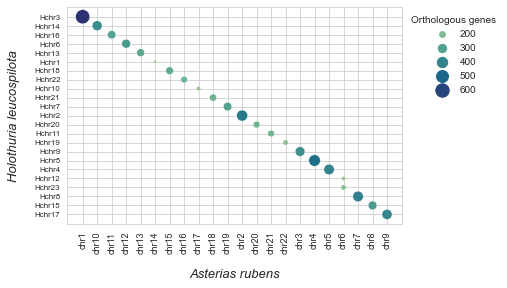

In [13]:
orthoplot(AH_data, 'A', 'H', 'Asterias rubens', 'Holothuria leucospilota')

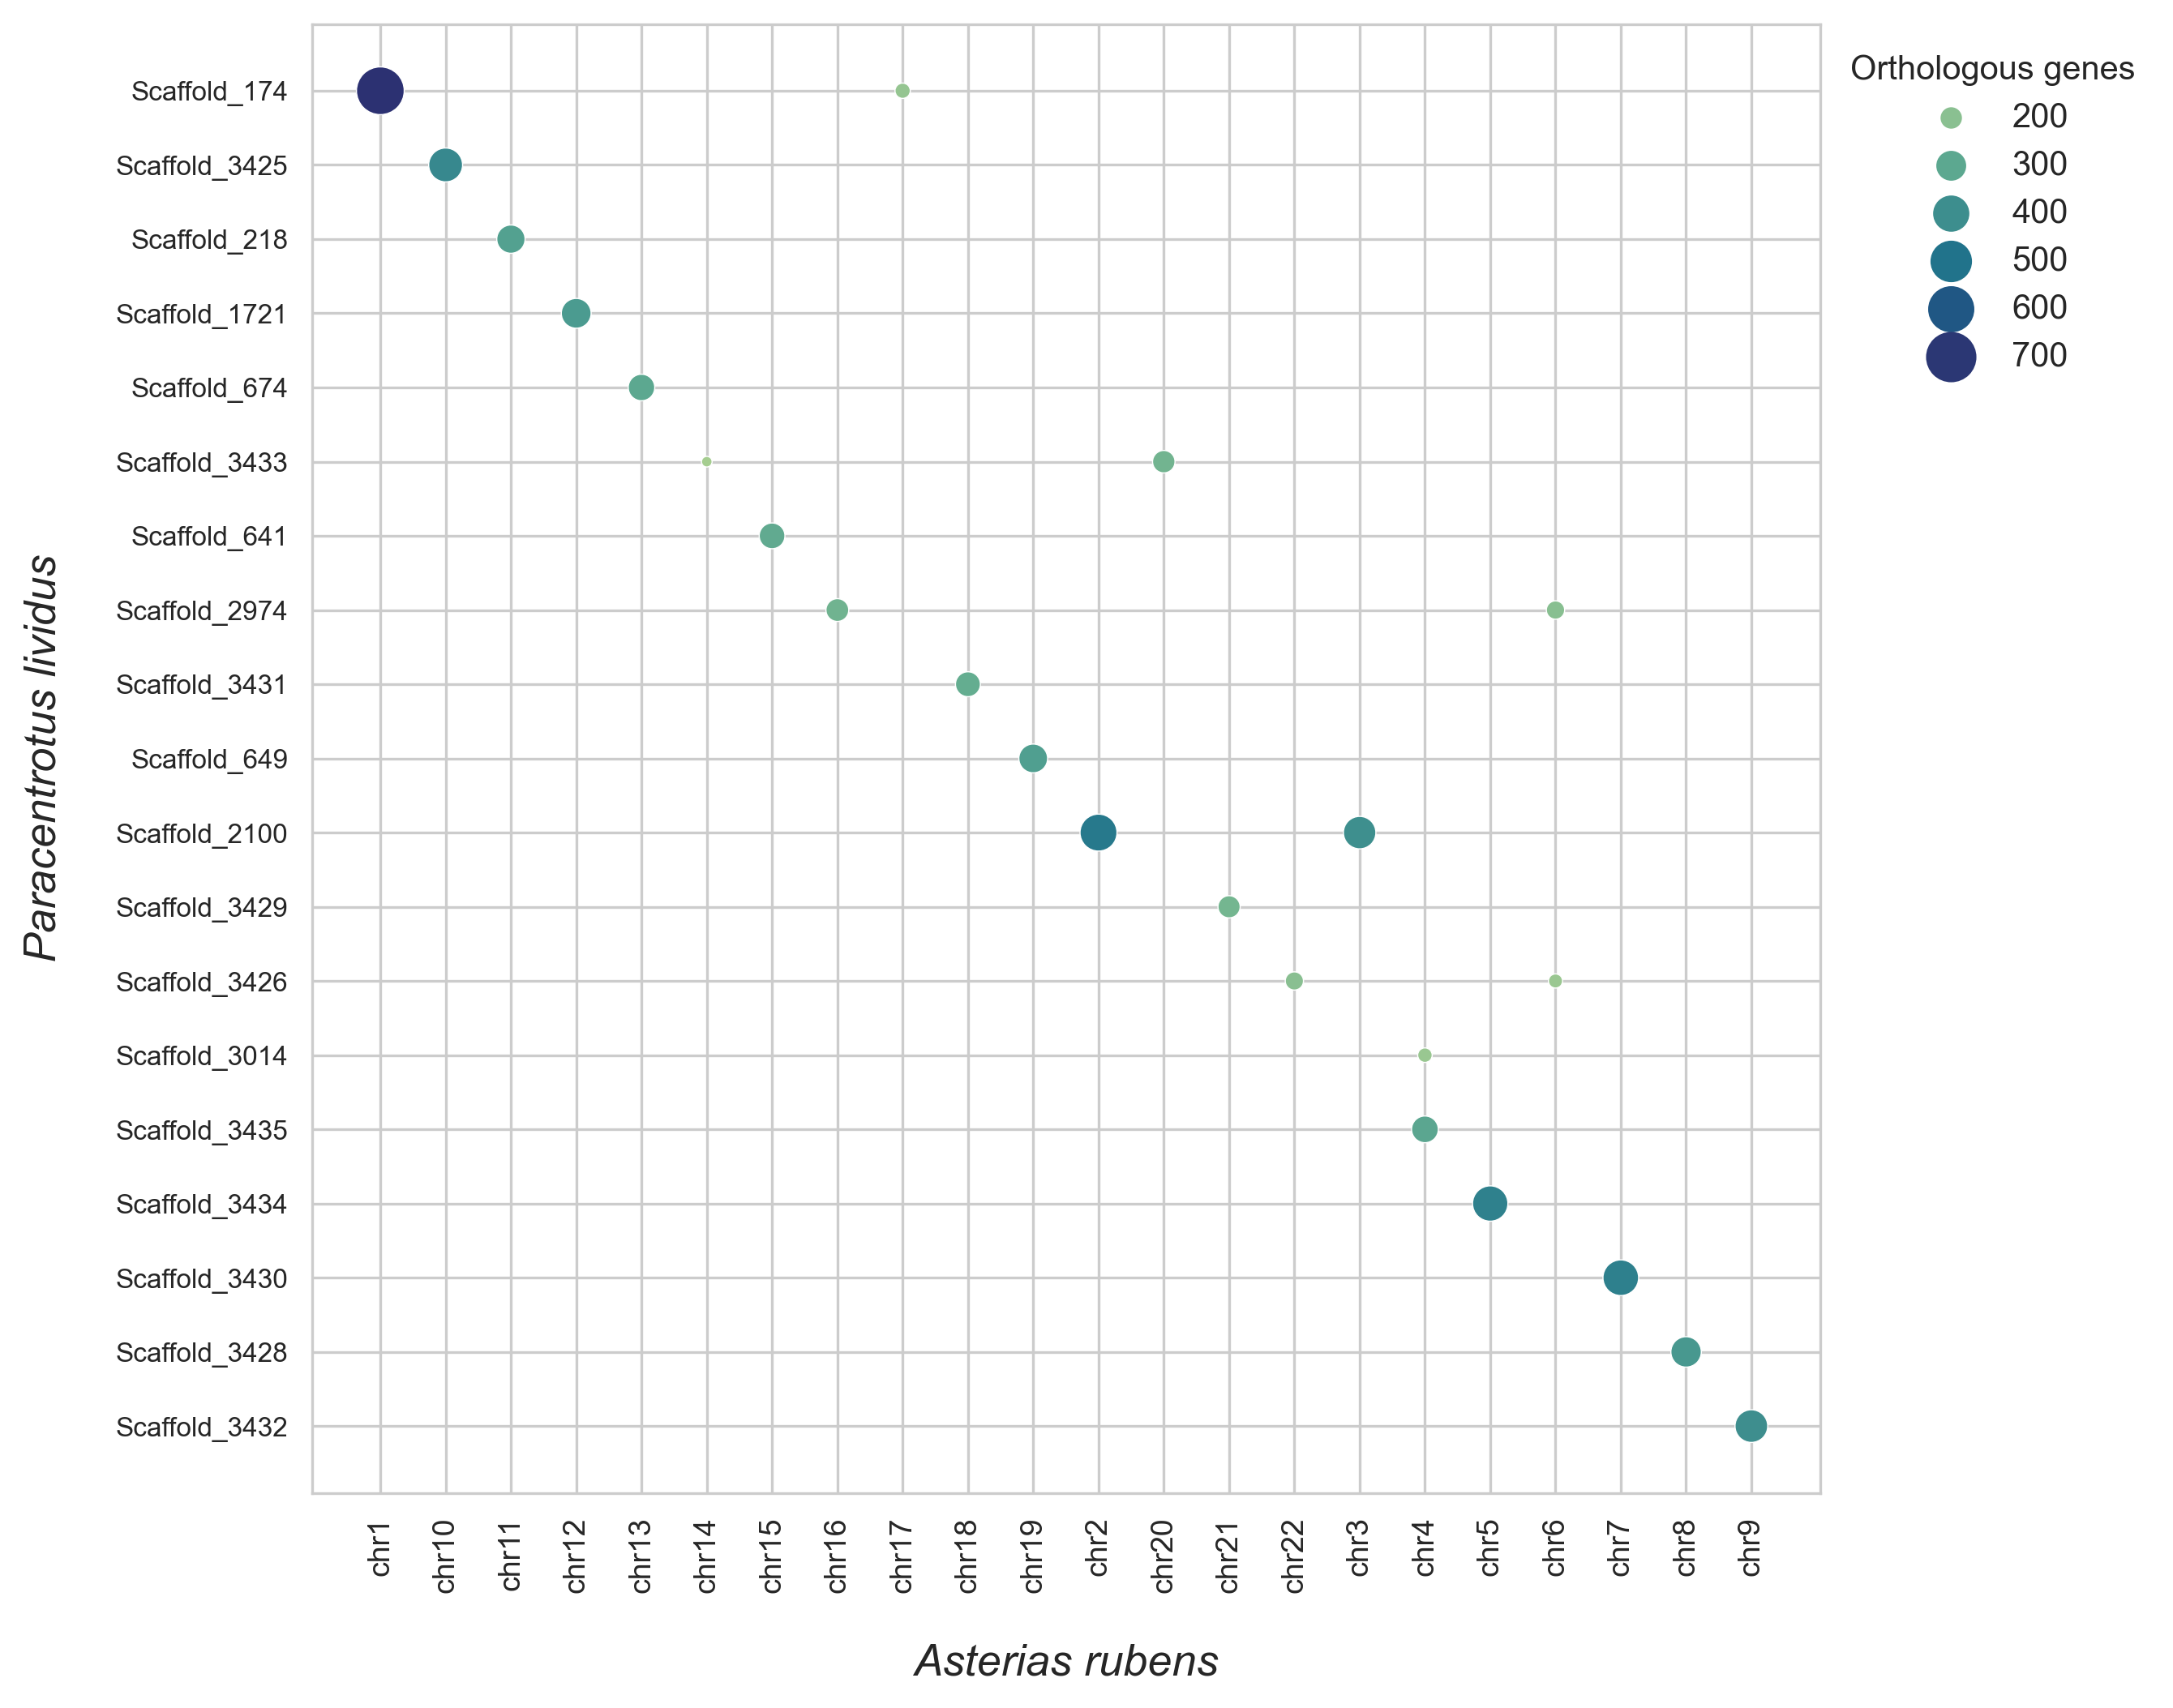

In [14]:
orthoplot(AP_data, 'A', 'P', 'Asterias rubens', 'Paracentrotus lividus')

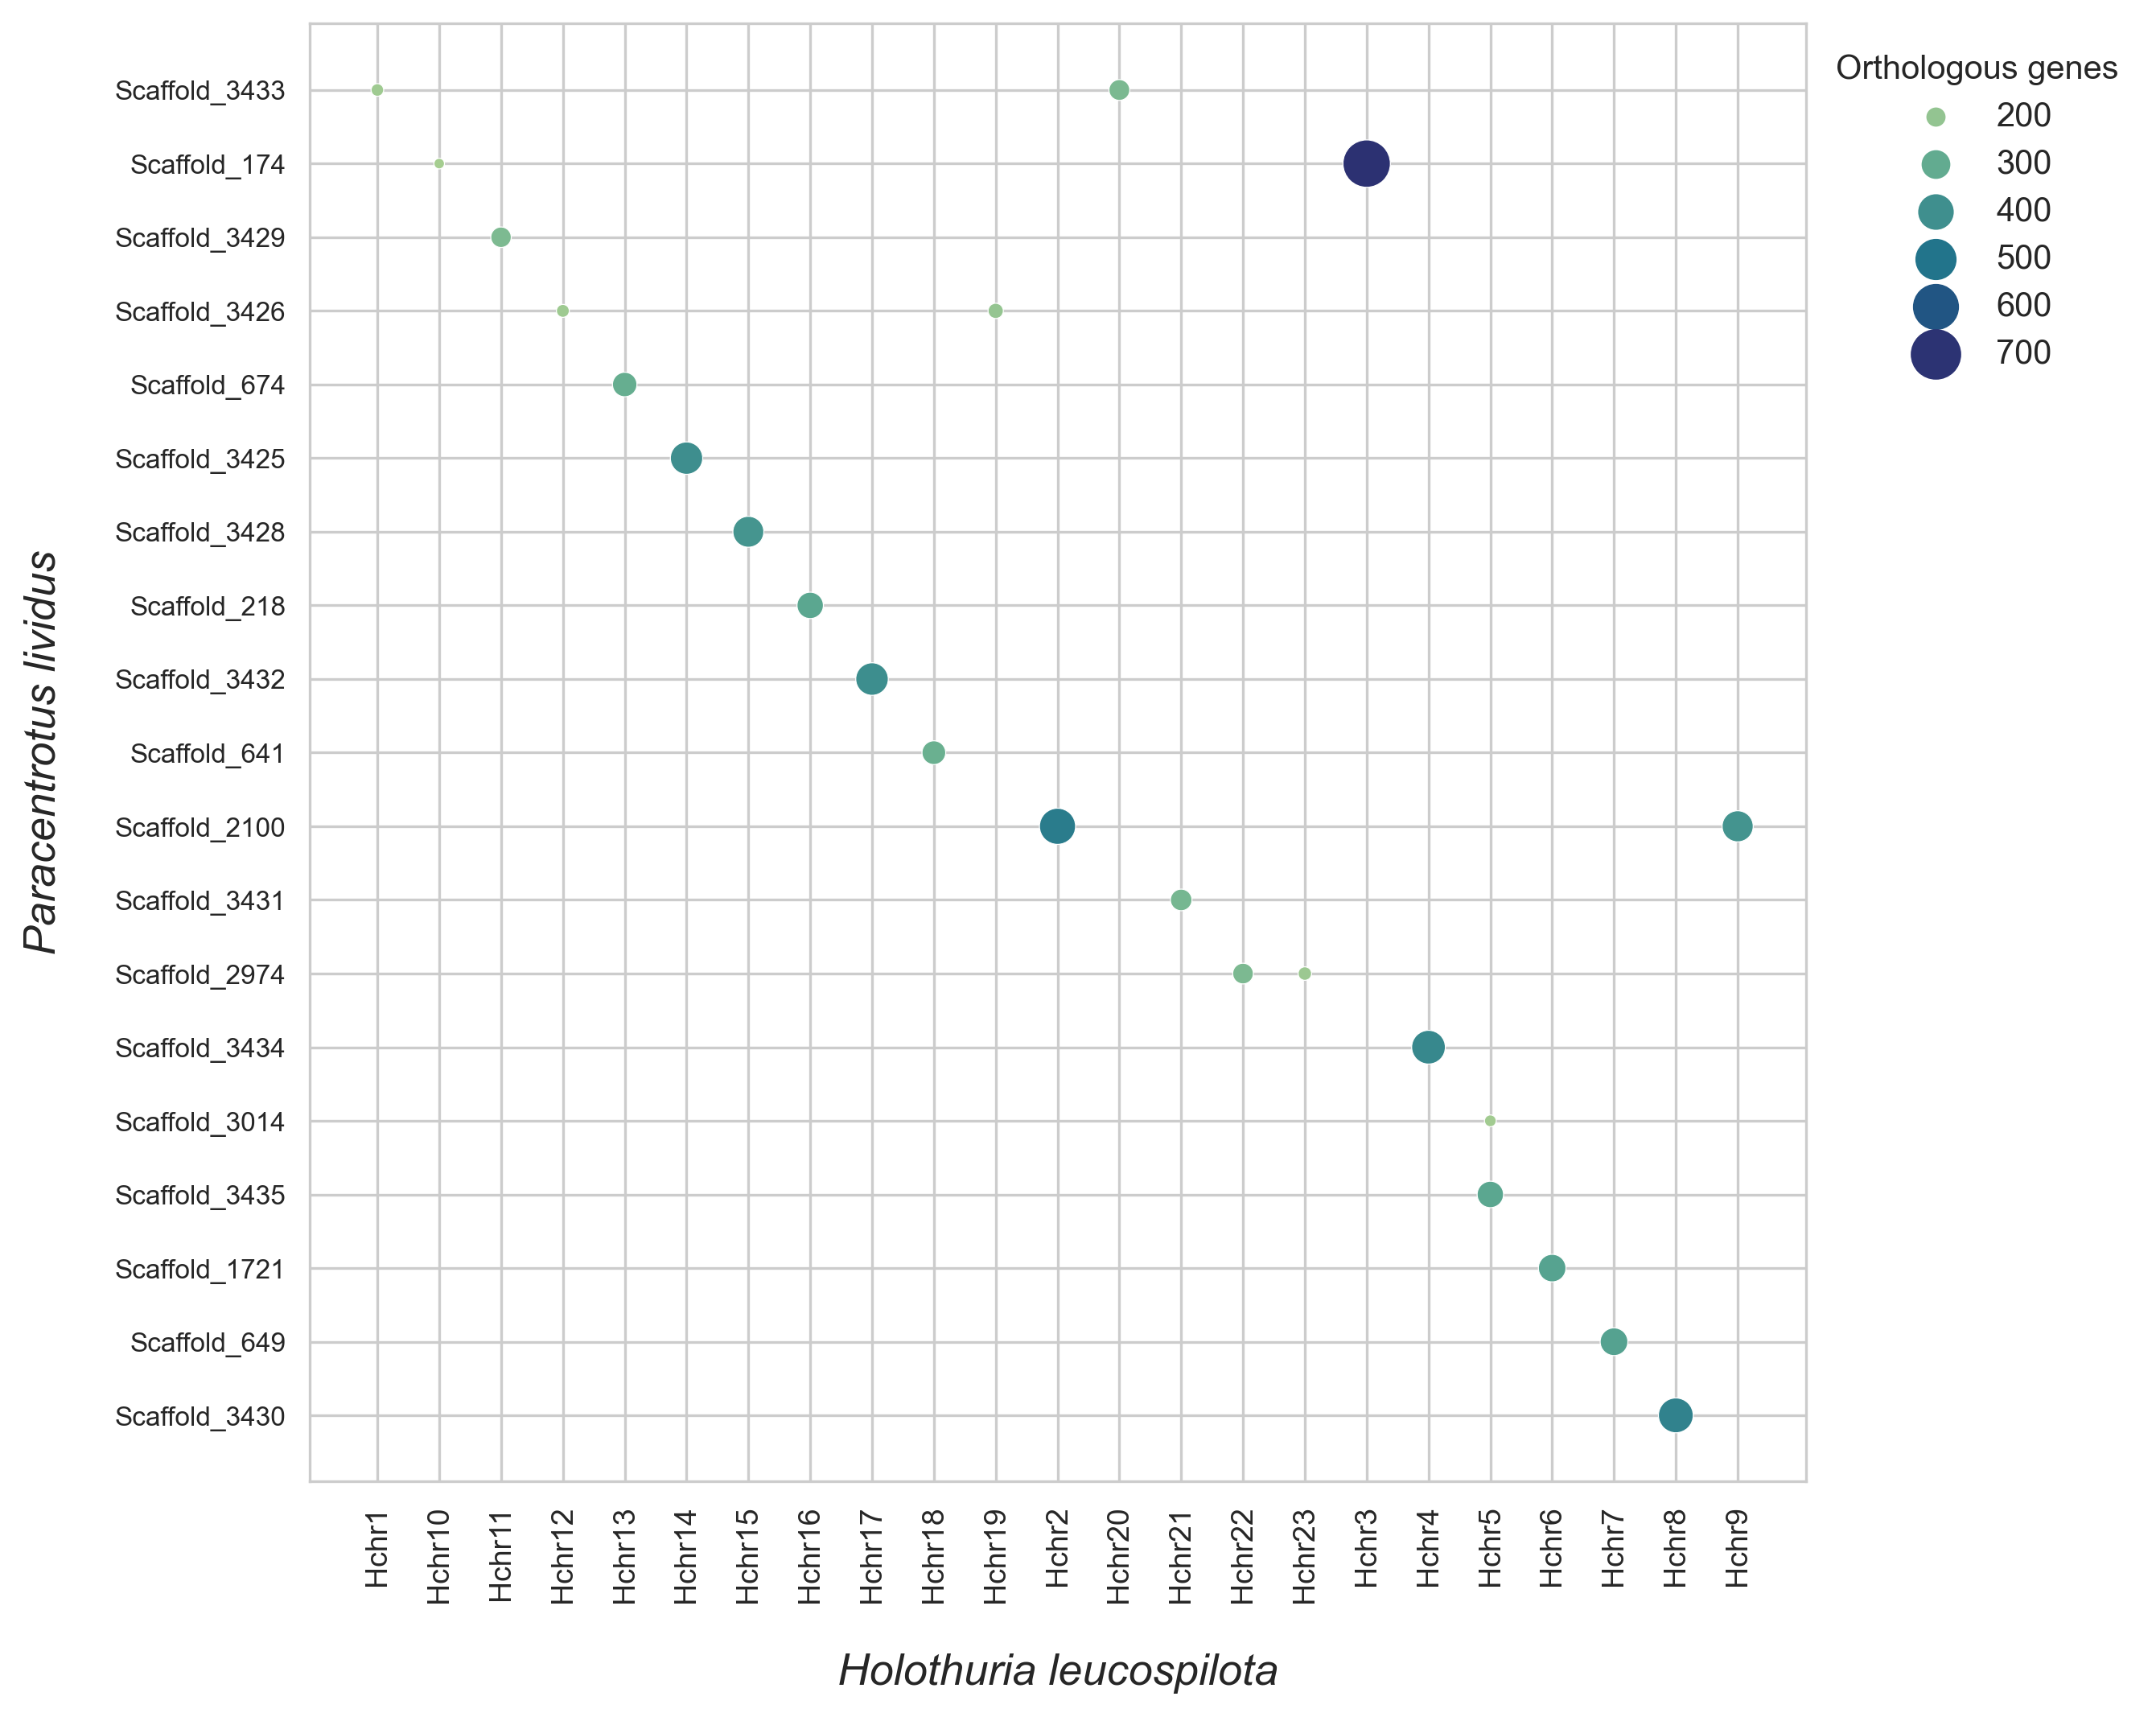

In [15]:
orthoplot(HP_data, 'H', 'P', 'Holothuria leucospilota', 'Paracentrotus lividus')